In [1]:
import math
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd
import numpy as np
from fiona.drvsupport import supported_drivers
from simplekml import Kml, Color
supported_drivers['KML'] = 'rw'
supported_drivers['libkml'] = 'rw' # enable KML support which is disabled by default
supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled 
import numpy as np
import geopandas as gpd
from simplekml import Kml, Color
import os
import time
from geopy.distance import geodesic

In [2]:
def generate_bins(geom, bin_size=10):

    x_ref, y_ref = 193602, 2602072
    xmin, ymin, xmax, ymax = geom.bounds
    # To shift the polygon to math the whole grid
    xmin = math.floor((xmin-x_ref)/bin_size)*bin_size+x_ref
    xmax = math.ceil((xmax-x_ref)/bin_size)*bin_size+x_ref
    ymin = math.floor((ymin-y_ref)/bin_size)*bin_size+y_ref
    ymax = math.ceil((ymax-y_ref)/bin_size)*bin_size+y_ref
    # Calculate the number of bins in each dimension
    xbins = int((xmax - xmin) / bin_size)
    ybins = int((ymax - ymin) / bin_size)
    # Create arrays of x and y coordinates for bins
    x_coords = np.arange(xmin, xmin + xbins * bin_size, bin_size)
    y_coords = np.arange(ymin, ymin + ybins * bin_size, bin_size)
    # Use NumPy's meshgrid to generate all combinations of x and y coordinates
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)
    # Flatten the arrays and create bin polygons using vectorized operations
    x_flat = x_grid.flatten()
    y_flat = y_grid.flatten()
    bin_polygons = [
        Polygon([
            (x, y), (x + bin_size, y), (x + bin_size, y + bin_size), (x, y + bin_size)
        ]) for x, y in zip(x_flat, y_flat)
    ]
    return bin_polygons

In [3]:
## Get border file and raw data file
area_name = "DN_KCN_AN_DON"
# area_name = "DN_KCN_HOA_KHANH"
# area_name = "QN_KCN_VSIP"
# area_name = "KH_QL1"
date_str = '050723'
bin_size = 10

input_polygon_file = f"../Polygon/{area_name}.kml"
polygon_df = gpd.read_file(input_polygon_file)
          
input_raw_file = f"../Raw/{area_name}/{area_name}_{date_str}.csv"
df_raw = pd.read_csv(input_raw_file)

# folder_path = f"../Raw/{area_name}/Pilot_{date_str}"
# print(f"Reading from multiple input raw files in {folder_path}")
# df_list = []
# for filename in os.listdir(folder_path):
#     if filename.endswith('.csv'):
#         file_path = os.path.join(folder_path, filename)
#         df = pd.read_csv(file_path, low_memory=False)
#         df_list.append(df)
# df_raw = pd.concat(df_list, ignore_index=True)

C:\Users\MLMT-DATTH-P\AppData\Local\Temp\ipykernel_23488\826172424.py:13: DtypeWarning: Columns (26,102,103,105,106,107,109) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(input_raw_file)


In [6]:
## Divide bins and locate points
print(f"***===RUNNING:{area_name}, {bin_size}*{bin_size} grid ==***")
### Read a Polygon and divide
polygon_df = polygon_df.to_crs('EPSG:32648')
bins_polygons = [generate_bins(geom, bin_size) for geom in polygon_df['geometry']]
bins_polygons = [bin_poly for sublist in bins_polygons for bin_poly in sublist]
# Create the GeoDataFrame for bins
bins_df = gpd.GeoDataFrame({'geometry': bins_polygons}, crs=polygon_df.crs)
bins_df['centroid'] = bins_df['geometry'].centroid
bins_df_4326 = bins_df.to_crs("EPSG:4326")
bins_df_4326['centroid'] = bins_df_4326['centroid'].to_crs("EPSG:4326")
bins_df_4326['longitude'] = bins_df_4326['centroid'].x
bins_df_4326['latitude'] = bins_df_4326['centroid'].y
bins_df_4326['bin_id'] = "bin" + "_" +bins_df_4326['latitude'].astype(str)+ "_" + bins_df_4326['longitude'].astype(str)
bins_df_4326 = bins_df_4326[['bin_id', 'geometry']]
print('==Complete dividing bins')
### Load raw data file
df_point = df_raw.copy()
df_point_columns = [
    'Start Time',
    'eNodeB',
    'EARFCN (DL)',
    'EARFCN (UL)',
    'Physical Cell ID',
    'Latitude',
    'Longitude',
    'UL Volume (kB)',
    'DL Volume (kB)',
    'CQI 0',
    'CQI 1',
    'CQI 2',
    'CQI 3',
    'CQI 4',
    'CQI 5',
    'CQI 6',
    'CQI 7',
    'CQI 8',
    'CQI 9',
    'CQI 10',
    'CQI 11',
    'CQI 12',
    'CQI 13',
    'CQI 14',
    'CQI 15',
    'Serving Cell Label',
    'Serving Cell RSRP',
    'Best Cell Label',
    'Best Cell RSRP',
    'Second Best Cell Label',
    'Second Best Cell RSRP',
    'Third Best Cell Label',
    'Third Best Cell RSRP',
    'Fourth Best Cell Label',
    'Fourth Best Cell RSRP',
    'Fifth Best Cell Label',
    'Fifth Best Cell RSRP',
    'Sixth Best Cell Label',
    'Sixth Best Cell RSRP',
]
df_point = df_point[df_point_columns]

### Locate bins for each sample
bins_df_4326.reset_index(inplace=True)
polygonDF = bins_df_4326.copy()
polygonDF = polygonDF[['bin_id','geometry']]
# Create Point Dataframe
geometric_points = []
for xy in zip(df_point['Longitude'], df_point['Latitude']):
    geometric_points.append(Point(xy))

pointDF = gpd.GeoDataFrame(df_point,
                                crs = {'init': 'epsg:4326'}, 
                                geometry = geometric_points
                                )
pointDF = pointDF.to_crs(polygonDF.crs)
# Join 2 DFs
joinDF = gpd.sjoin(pointDF,polygonDF, how='inner', predicate='within')
joinDF['polygon'] = joinDF['index_right'].map(polygonDF['geometry'])
print('==Complete Locating point')

### Preprocessing
df_segment = joinDF.copy()
df_segment = df_segment[df_segment['polygon'].notna()]
df_segment = df_segment.dropna(subset='Best Cell Label')
df_segment['polygon_str'] = df_segment['polygon'].astype(str)

***===RUNNING:DN_KCN_AN_DON, 10*10 grid ==***
==Complete dividing bins


c:\Users\MLMT-DATTH-P\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


==Complete Locating point


In [7]:
## Pilot pollution
# Pilot Pollution
pilot_columns = [
    'bin_id',
    'polygon_str',
    'Serving Cell Label',
    'Serving Cell RSRP',
    'Best Cell Label',
    'Best Cell RSRP',
    'Second Best Cell Label',
    'Second Best Cell RSRP',
    'Third Best Cell Label',
    'Third Best Cell RSRP',
    'Fourth Best Cell Label',
    'Fourth Best Cell RSRP',
    'Fifth Best Cell Label',
    'Fifth Best Cell RSRP',
    'Sixth Best Cell Label',
    'Sixth Best Cell RSRP'
]
df_pilot = df_segment[pilot_columns]
df_pilot['rsrp_margin'] = df_pilot['Best Cell RSRP'] - 5
n_bestcell_clumns = [
    'rsrp_margin',
    'Second Best Cell RSRP',
    'Third Best Cell RSRP',
    'Fourth Best Cell RSRP',
    'Fifth Best Cell RSRP',
    'Sixth Best Cell RSRP'
]
compare_column = 'rsrp_margin'
df_pilot['pilot_polution'] = df_pilot[n_bestcell_clumns].apply(lambda row: sum(row[1:] > row[compare_column]), axis=1)
df_pilot_agg = df_pilot[['bin_id', 'polygon_str', 'pilot_polution']].copy()
df_pilot_agg_mean = df_pilot_agg.groupby('polygon_str').mean()
df_pilot_agg_count = df_pilot_agg.groupby('polygon_str').count()
df_pilot_agg = df_pilot_agg_mean
df_pilot_agg['No.Samples'] = df_pilot_agg_count['pilot_polution']
df_pilot_agg.reset_index(inplace=True)

C:\Users\MLMT-DATTH-P\AppData\Local\Temp\ipykernel_23488\2313400041.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pilot['rsrp_margin'] = df_pilot['Best Cell RSRP'] - 5
C:\Users\MLMT-DATTH-P\AppData\Local\Temp\ipykernel_23488\2313400041.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pilot['pilot_polution'] = df_pilot[n_bestcell_clumns].apply(lambda row: sum(row[1:] > row[compare_column]), axis=1)
C:\Users\MLMT-DATTH-P\AppData\Local\Temp\ipykernel_23488\2313400041.py:34: FutureWarning: The 

In [6]:
# from pilot import save_output_to_kml
# save_output_to_kml(df_pilot_agg.reset_index(drop=True), 'pilot_polution', 'pilot_pollution', 'pilot')

In [14]:
df = df_pilot_agg[df_pilot_agg['No.Samples'] >= 3].copy()
df['polygon_str'] = df['polygon_str'].str.replace('POLYGON ', '', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False)
df['geometry'] = df['polygon_str'].apply(lambda x: Polygon([tuple(map(float, c.split())) for c in x.split(',')]))
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.crs = "epsg:4326"
gdf = gdf.to_crs('EPSG:32648')
gdf['center_point'] = gdf['geometry'].centroid
gdf['latitude'] = gdf['center_point'].y
gdf['longitude'] = gdf['center_point'].x
pilot_range = [-float('inf'), 1.33, float('inf')]
gdf['pilot'] = pd.cut(gdf['pilot_polution'], bins=pilot_range, labels=False)
gdf


,polygon_str,pilot_polution,No.Samples,geometry,center_point,latitude,longitude,pilot
0,"108.232051 16.073443, 108.232145 16.073442, 10...",0.464286,28,"POLYGON ((845831.982 1779761.961, 845842.051 1...",POINT (845837.009 1779766.989),1.779767e+06,845837.008881,0
1,"108.232053 16.073534, 108.232146 16.073532, 10...",0.384615,13,"POLYGON ((845832.038 1779772.044, 845842.002 1...",POINT (845836.996 1779776.997),1.779777e+06,845836.995825,0
3,"108.232143 16.073352, 108.232236 16.07335, 108...",0.810811,74,"POLYGON ((845841.992 1779752.036, 845851.956 1...",POINT (845847.012 1779757.016),1.779757e+06,845847.012094,0
4,"108.232145 16.073442, 108.232238 16.073441, 10...",0.777778,9,"POLYGON ((845842.051 1779762.008, 845852.013 1...",POINT (845847.007 1779767.016),1.779767e+06,845847.007267,0
6,"108.232147 16.073622, 108.232241 16.073621, 10...",0.176471,51,"POLYGON ((845841.953 1779781.949, 845852.022 1...",POINT (845846.980 1779786.977),1.779787e+06,845846.980236,0
...,...,...,...,...,...,...,...,...
3481,"108.239108 16.076767, 108.239201 16.076766, 10...",1.379310,29,"POLYGON ((846582.002 1780141.977, 846591.964 1...",POINT (846586.985 1780146.995),1.780147e+06,846586.985176,1
3482,"108.239109 16.076857, 108.239203 16.076856, 10...",1.000000,84,"POLYGON ((846581.953 1780151.948, 846592.022 1...",POINT (846586.980 1780156.976),1.780157e+06,846586.979672,0
3483,"108.239111 16.076948, 108.239204 16.076946, 10...",1.100000,10,"POLYGON ((846582.009 1780162.031, 846591.973 1...",POINT (846587.002 1780167.020),1.780167e+06,846587.001950,0
3485,"108.239201 16.076766, 108.239295 16.076764, 10...",0.787879,99,"POLYGON ((846591.964 1780142.023, 846602.034 1...",POINT (846597.010 1780146.995),1.780147e+06,846597.009828,0


c:\Users\MLMT-DATTH-P\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Text(0.5, 1.0, 'DBSCAN Clustering')

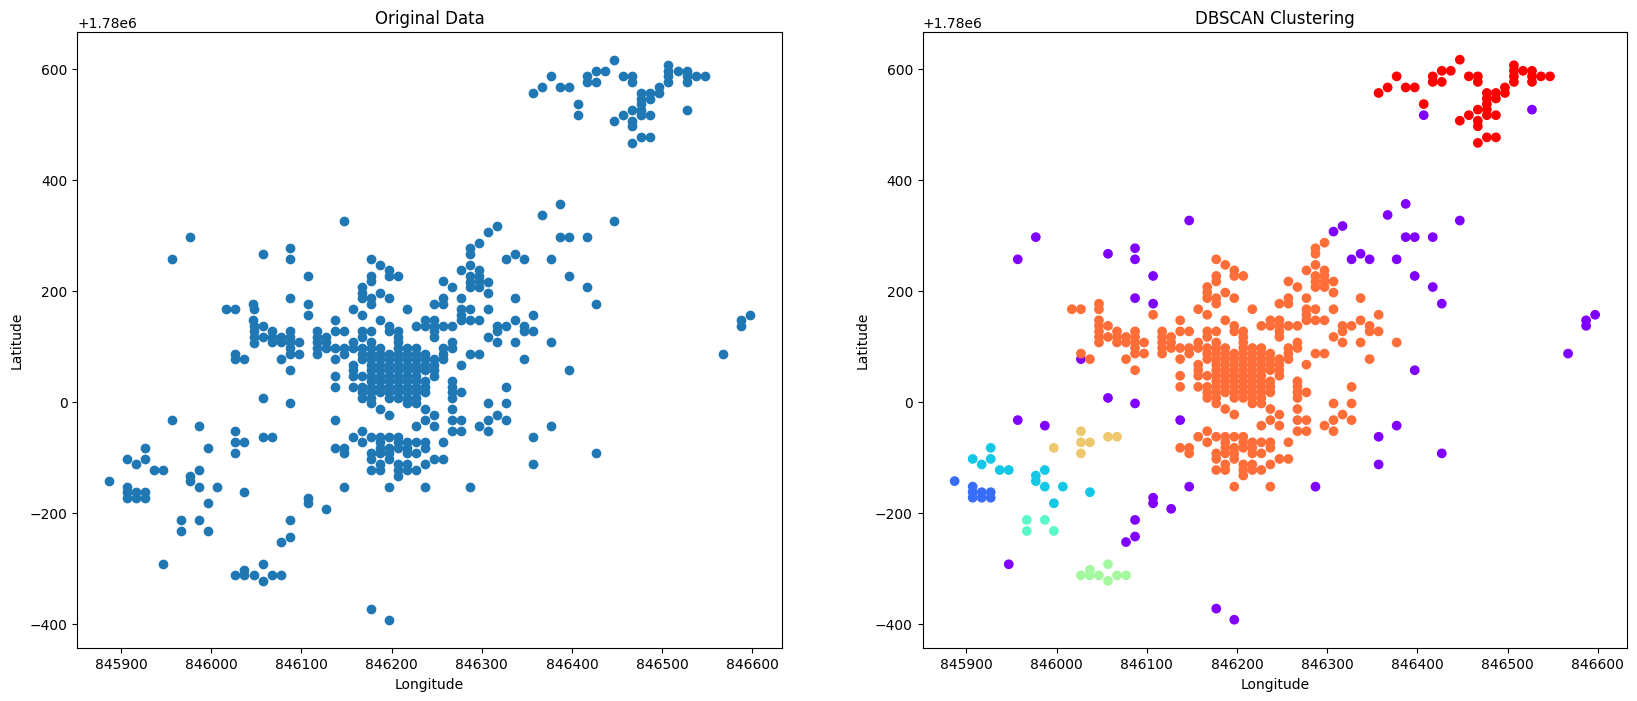

In [15]:
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# gdf[['longitude', 'latitude']] = scaler.fit_transform(gdf[['longitude', 'latitude']])
gdf = gdf[gdf['pilot'] == 1]
X = gdf[['longitude', 'latitude']]

# Create a DBSCAN model
eps =  35 # Epsilon (maximum distance between points in a cluster)
min_samples = 5  # Minimum number of samples to form a core point
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
# dbscan = DBSCAN()

# Fit the model to your data
labels = dbscan.fit_predict(X)

# Add cluster labels to the DataFrame
gdf['cluster'] = labels

# Plot the clusters
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)  # First subplot in a 2x2 grid
plt.scatter(gdf['longitude'], gdf['latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Original Data')

plt.subplot(1, 2, 2)  # Second subplot in a 2x2 grid
plt.scatter(gdf['longitude'], gdf['latitude'], c=labels, cmap='rainbow')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering')

In [10]:
from pilot import save_output_to_kml
save_output_to_kml(gdf.reset_index(drop=True), 'pilot_polution', 'pilot_pollution', 'pilot')

In [16]:
gdf1 = gdf[gdf['cluster'] != -1][['geometry','cluster']].to_crs('EPSG:4326')

In [17]:
gdf1

,geometry,cluster
48,"POLYGON ((108.23253 16.07425, 108.23262 16.074...",0
76,"POLYGON ((108.23271 16.07398, 108.23281 16.073...",0
77,"POLYGON ((108.23271 16.07407, 108.23281 16.074...",0
78,"POLYGON ((108.23272 16.07416, 108.23281 16.074...",0
83,"POLYGON ((108.23272 16.07461, 108.23282 16.074...",1
...,...,...
3421,"POLYGON ((108.23861 16.08066, 108.23870 16.080...",6
3422,"POLYGON ((108.23861 16.08075, 108.23871 16.080...",6
3423,"POLYGON ((108.23861 16.08084, 108.23871 16.080...",6
3446,"POLYGON ((108.23871 16.08075, 108.23880 16.080...",6


In [12]:
import geopandas as gpd
import shapely.geometry as sg
import simplekml

# Initialize KML object
kml = simplekml.Kml()

# Group polygons by cluster
grouped = gdf1.groupby('cluster')

# Create polygons and outlines for each group
for cluster, group in grouped:
    # Combine the geometries of polygons in the same cluster
    combined_geometry = sg.MultiPolygon(list(group['geometry']))
    
    # Create a bounding box polygon around the combined geometry
    bounding_box = combined_geometry.envelope
    
    placemark = kml.newpolygon(
        outerboundaryis=list(bounding_box.exterior.coords),
        name=f'Cluster {cluster} Outline',
        altitudemode=simplekml.AltitudeMode.clamptoground,
    )

# Save the KML file
kml_file_path = 'cluster_outlines.kml'
kml.save(kml_file_path)


In [24]:
gdf = gdf1.copy()
gdf

,geometry,cluster
48,"POLYGON ((108.23253 16.07425, 108.23262 16.074...",0
76,"POLYGON ((108.23271 16.07398, 108.23281 16.073...",0
77,"POLYGON ((108.23271 16.07407, 108.23281 16.074...",0
78,"POLYGON ((108.23272 16.07416, 108.23281 16.074...",0
83,"POLYGON ((108.23272 16.07461, 108.23282 16.074...",1
...,...,...
3421,"POLYGON ((108.23861 16.08066, 108.23870 16.080...",6
3422,"POLYGON ((108.23861 16.08075, 108.23871 16.080...",6
3423,"POLYGON ((108.23861 16.08084, 108.23871 16.080...",6
3446,"POLYGON ((108.23871 16.08075, 108.23880 16.080...",6


In [25]:
import geopandas as gpd
from shapely.geometry import MultiPolygon

# Assuming you have your GeoPandas DataFrame 'gdf'

# Group the DataFrame by the "cluster" column and aggregate the polygons into MultiPolygons
grouped_gdf = gdf.groupby('cluster')['geometry'].apply(lambda x: MultiPolygon(list(x))).reset_index()

# Create a new GeoDataFrame with the MultiPolygons
multi_polygon_gdf = gpd.GeoDataFrame(grouped_gdf, geometry='geometry', crs=gdf.crs)

# Rename the "cluster" column if needed
multi_polygon_gdf = multi_polygon_gdf.rename(columns={'cluster': 'cluster_id'})

# Now, 'multi_polygon_gdf' contains MultiPolygons based on the "cluster" column
multi_polygon_gdf


,cluster_id,geometry
0,0,"MULTIPOLYGON (((108.23253 16.07425, 108.23262 ..."
1,1,"MULTIPOLYGON (((108.23272 16.07461, 108.23282 ..."
2,2,"MULTIPOLYGON (((108.23327 16.07343, 108.23336 ..."
3,3,"MULTIPOLYGON (((108.23381 16.07269, 108.23391 ..."
4,4,"MULTIPOLYGON (((108.23357 16.07477, 108.23366 ..."
5,5,"MULTIPOLYGON (((108.23379 16.07703, 108.23388 ..."
6,6,"MULTIPOLYGON (((108.23702 16.08050, 108.23711 ..."


In [30]:
# Create an empty list to store the individual boundary polygons
boundary_polygons = []

# Iterate through each row in the DataFrame
for index, row in multi_polygon_gdf.iterrows():
    # Extract the geometry of the current row
    geometry = row['geometry']
    
    # Calculate the boundary of the current MULTIPOLYGON
    boundary = geometry.envelope
    
    # Append the boundary polygon to the list
    boundary_polygons.append(boundary)

# Create a new GeoDataFrame from the list of boundary polygons
boundary_gdf = gpd.GeoDataFrame({'geometry': boundary_polygons}, crs=multi_polygon_gdf.crs)

# Now, 'boundary_gdf' contains individual boundary polygons for each row
boundary_gdf



,geometry
0,"POLYGON ((108.23253 16.07397, 108.23300 16.073..."
1,"POLYGON ((108.23272 16.07387, 108.23402 16.073..."
2,"POLYGON ((108.23327 16.07342, 108.23364 16.073..."
3,"POLYGON ((108.23381 16.07260, 108.23438 16.072..."
4,"POLYGON ((108.23357 16.07468, 108.23432 16.074..."
5,"POLYGON ((108.23379 16.07411, 108.23724 16.074..."
6,"POLYGON ((108.23702 16.07967, 108.23889 16.079..."


In [32]:
import geopandas as gpd
from shapely.ops import unary_union

gdf = boundary_gdf.copy()
# Find the intersections between polygons and create a dictionary to track groups
intersection_dict = {}
group_id = 0

for idx, polygon in gdf.iterrows():
    # Check if the current polygon intersects with any existing group
    intersects = False
    for key, group in intersection_dict.items():
        if polygon['geometry'].intersects(group):
            intersection_dict[key] = unary_union([group, polygon['geometry']])
            intersects = True
            break
    
    # If the current polygon doesn't intersect with any existing group, create a new group
    if not intersects:
        intersection_dict[group_id] = polygon['geometry']
        group_id += 1

# Create a GeoDataFrame from the grouped polygons
grouped_gdf = gpd.GeoDataFrame({'geometry': list(intersection_dict.values())}, crs=gdf.crs)

# Now, 'grouped_gdf' contains polygons grouped by intersections
grouped_gdf


,geometry
0,"POLYGON ((108.23272 16.07434, 108.23272 16.074..."
1,"POLYGON ((108.23327 16.07342, 108.23364 16.073..."
2,"POLYGON ((108.23381 16.07260, 108.23438 16.072..."
3,"POLYGON ((108.23702 16.07967, 108.23889 16.079..."


In [33]:
grouped_gdf.to_file('cluster_outlines_1.kml', driver='KML')